In [1]:
from __future__ import print_function
import warnings
warnings.filterwarnings("ignore")
import matplotlib
import matplotlib.pyplot as plt
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import sys
sys.path.append('/home/jonathak/VisualEncoder/DIP_decoder/GP-DIP/')
import numpy as np
from models import *
import torch
import torch.optim
import time
from skimage.metrics import peak_signal_noise_ratio as compare_psnr
from utils.denoising_utils import *
import _pickle as cPickle
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark =True
dtype = torch.cuda.FloatTensor
import seaborn as sns
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

# display images
def np_plot(np_matrix, title):
    plt.clf()
    fig = plt.imshow(np_matrix.transpose(1, 2, 0), interpolation = 'nearest')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    plt.title(title)
    plt.axis('off')
    plt.pause(0.05) 

Load encoder model

In [2]:
import os
import sys

import torch 

sys.path.append('/home/romanb/PycharmProjects/BrainVisualReconst/')
encoder = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14_reg')


model = torch.load('/home/romanb/data/NSD_models/dino_v2_ml_NSD.pth').eval().cuda()

Using cache found in /home/jonathak/.cache/torch/hub/facebookresearch_dinov2_main


Load data

In [3]:
import numpy as np
val_sub1 = True

from sklearn.model_selection import train_test_split

data_dir = '/net/mraid11/export/data/navvew/algonauts_2023_challenge_data'
num_voxels_subjects = np.load(data_dir + '/num_voxels_all_subjects.npy')

num_voxels_subjects = num_voxels_subjects.sum(1).astype(int)


data_dir = "/home/romanb/data/datasets/NVD/tutorial_data/subjects/subsuper/"
imgs = np.load(data_dir+"all_images.npy")
print(imgs.max(),imgs.min())


lvc_bitmap = np.load(data_dir+"lvc_bitmap.npy")
fmri_files = np.load(data_dir+"fmri.npz")

type_sample = fmri_files["type_sample"]
single_sub_fmri = fmri_files["single_sub_fmri"]
single_sub = fmri_files["single_sub"].astype(int)
multi_sub_fmri = fmri_files["multi_sub_fmri"]

imgs_single = imgs[type_sample==1]
imgs_multi = imgs[type_sample==2]

#sub0_ind = np.where(single_sub == 0)[0]
#subnot0_ind = np.where(single_sub != 0)[0]

single_sub_fmri_train, single_sub_fmri_val, single_sub_train, single_sub_val, imgs_single_train, imgs_single_val = train_test_split(single_sub_fmri,single_sub, imgs_single , test_size=0.1, random_state = 10)


single_sub_fmri_train  = single_sub_fmri_train
single_sub_train       = single_sub_train
imgs_single_train    = imgs_single_train

if(val_sub1):
    select = (single_sub_val == 0)
    single_sub_fmri_val = single_sub_fmri_val[select]
    single_sub_val      = single_sub_val[select]
    imgs_single_val   = imgs_single_val[select]

num_vox = num_voxels_subjects[0]
NC = np.load("/home/romanb/data/datasets/NVD/tutorial_data/noise_ceiling/noise_ceiling.npy")
select = NC[:num_vox]>0.5


## selects voxels with snr>0.5
inds = np.where(NC[:num_vox]>0.5)[0]
inds_torch = torch.from_numpy(inds)

255 0


DIP params

In [4]:
INPUT = 'noise'
pad = 'reflection'
OPT_OVER = 'net' # optimize over the net parameters only
c = 1./30.
reg_noise_std = 1./30.

learning_rate = LR = 0.001
exp_weight=0.99
input_depth = 32 
roll_back = True # to prevent numerical issues
num_iter = 501 # max iterations
burnin_iter = 7000 # burn-in iteration for SGLD
weight_decay = 5e-8
show_every =  50
mse = torch.nn.MSELoss().type(dtype) # loss
#img_noisy_torch = np_to_torch(img_rec).type(dtype)

In [5]:
mean = torch.tensor((0.485, 0.456, 0.406)).reshape(1,3,1,1).cuda()
std = torch.tensor((0.229, 0.224, 0.225)).reshape(1,3,1,1).cuda()

def trans_imgs(imgs):
    imgs = imgs/255.0
    imgs =  imgs.transpose([2,0,1])
    imgs =  torch.from_numpy(imgs.astype(float)).float()
    return imgs

Fit image

Starting optimization with ADAM
img min max:
0.8322749 0.14827873
loss tensor(0.0493, device='cuda:0', grad_fn=<MseLossBackward0>)


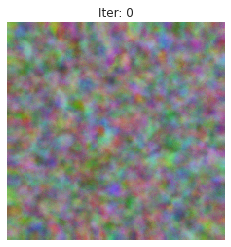

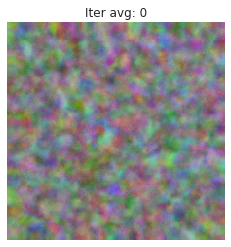

img min max:
0.8322749 0.14827873
loss tensor(0.0040, device='cuda:0', grad_fn=<MseLossBackward0>)


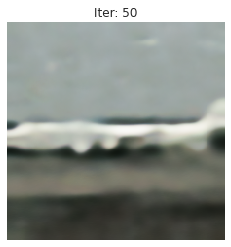

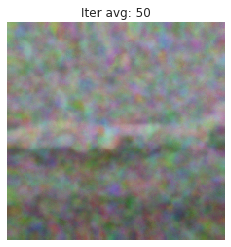

img min max:
0.8322749 0.14827873
loss tensor(0.0029, device='cuda:0', grad_fn=<MseLossBackward0>)


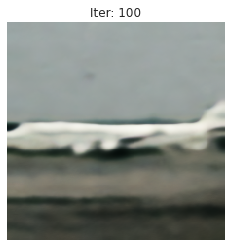

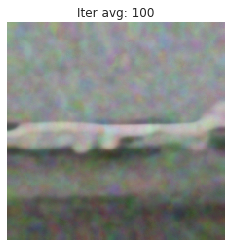

img min max:
0.8322749 0.14827873
loss tensor(0.0024, device='cuda:0', grad_fn=<MseLossBackward0>)


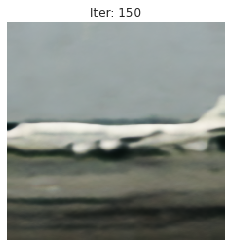

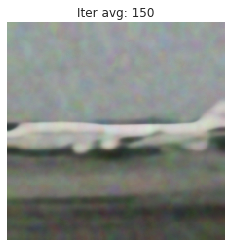

img min max:
0.8322749 0.14827873
loss tensor(0.0019, device='cuda:0', grad_fn=<MseLossBackward0>)


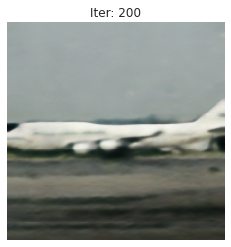

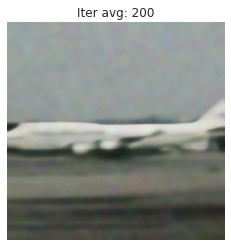

img min max:
0.8322749 0.14827873
loss tensor(0.0016, device='cuda:0', grad_fn=<MseLossBackward0>)


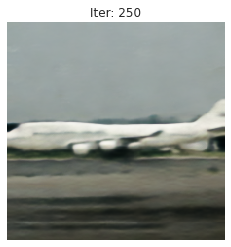

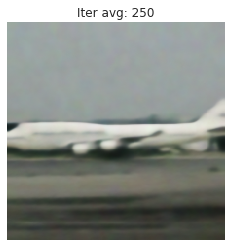

img min max:
0.8322749 0.14827873
loss tensor(0.0014, device='cuda:0', grad_fn=<MseLossBackward0>)


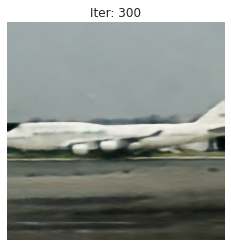

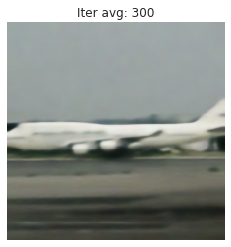

img min max:
0.8322749 0.14827873
loss tensor(0.0012, device='cuda:0', grad_fn=<MseLossBackward0>)


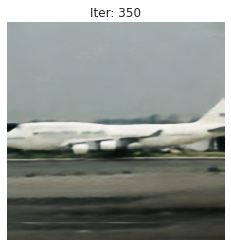

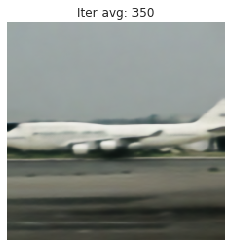

img min max:
0.8322749 0.14827873
loss tensor(0.0010, device='cuda:0', grad_fn=<MseLossBackward0>)


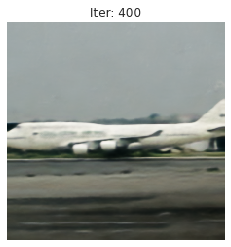

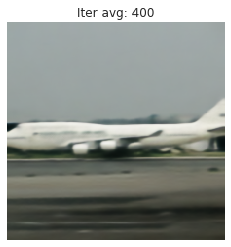

img min max:
0.8322749 0.14827873
loss tensor(0.0009, device='cuda:0', grad_fn=<MseLossBackward0>)


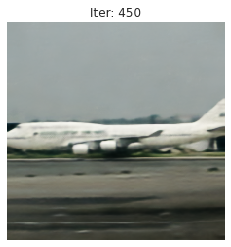

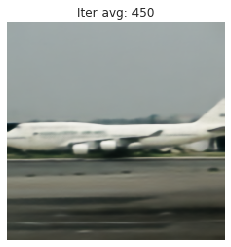

img min max:
0.8322749 0.14827873
loss tensor(0.0008, device='cuda:0', grad_fn=<MseLossBackward0>)


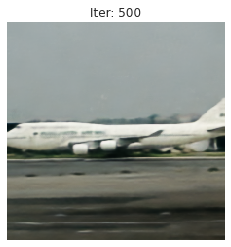

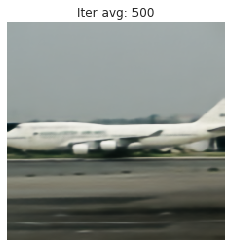

In [6]:
import torch.nn.functional as F


in_img = trans_imgs(imgs_single_val[30])


net = get_net(input_depth, 'skip', pad,
            skip_n33d=128, 
            skip_n33u=128,
            skip_n11=2,
            num_scales=3,
            upsample_mode='bilinear').type(dtype)

## Optimize
net_input = get_noise(input_depth, INPUT, (224, 224),var=0.1).type(dtype).detach()
net_input_saved = net_input.detach().clone()
noise = net_input.detach().clone()
out_avg = None
last_net = None
psrn_noisy_last = 0
i = 0

out = net(net_input)
rec_img_np = out.detach().cpu().numpy()[0]



# save tmp PSNR for different learning strategies
fancy_sgd_noise_psnr_list = [] # psnr between out and noise image
fancy_sgd_psnr_list = [] # psnr between sgd out and gt
fancy_sgd_expm_psnr_list = [] # psnr between exp avg and gt
fancy_sgd_out_1800 = None
fancy_sgd_expm_out_1800 = None
def closure():

    global i, out_avg, psrn_noisy_last, last_net, net_input
    if reg_noise_std > 0:
        net_input = net_input_saved + (noise.normal_() * reg_noise_std)
    out = net(net_input)

    if out_avg is None:
        out_avg = out.detach()
    else:
        out_avg = out_avg * exp_weight + out.detach() * (1 - exp_weight)
    
    #enc_in = (sigmoid(out)-mean)/std
    #vox_pred = model(enc_in, torch.arange(num_vox).unsqueeze(0).cuda() )
    
    loss = F.mse_loss(out, in_img.cuda())

    if i % show_every == 0:

        print('img min max:')
        print(rec_img_np.max(),rec_img_np.min())
        
        
        print('loss',loss)
        #print('mae',mae)


    #grad = grad.transpose(0,3,1,2)

    #grad_torch = np_to_torch(grad).type(dtype)
    
    
    #total_loss = torch.sum(out* grad_torch)
    loss.backward()

    out_np = out.detach().cpu().numpy()[0]
    out_avg_np = out_avg.detach().cpu().numpy()[0]

    if i % show_every == 0:
        np_plot(out.detach().cpu().numpy()[0], 'Iter: '+str(i))
        np_plot(out_avg_np, 'Iter avg: '+str(i))

    i += 1
    return loss

## Optimizing 
print('Starting optimization with ADAM')
optimizer = torch.optim.Adam(net.parameters(), lr=LR)
for j in range(num_iter):
    optimizer.zero_grad()
    closure()
    optimizer.step()

torch.cuda.empty_cache()

inverse encoder starting from correct image

Starting optimization with ADAM
img min max:
0.8322749 0.14827873
loss tensor(0.1152, device='cuda:0', grad_fn=<MseLossBackward0>)


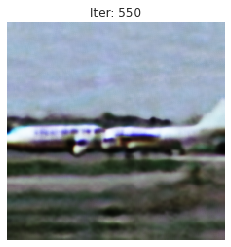

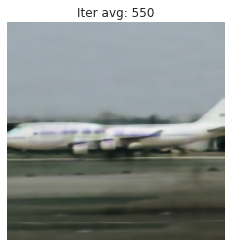

img min max:
0.8322749 0.14827873
loss tensor(0.1067, device='cuda:0', grad_fn=<MseLossBackward0>)


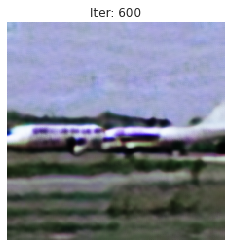

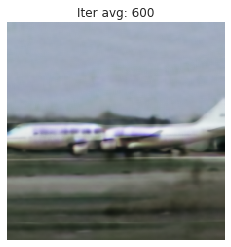

img min max:
0.8322749 0.14827873
loss tensor(0.1037, device='cuda:0', grad_fn=<MseLossBackward0>)


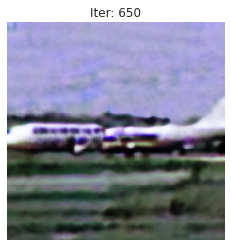

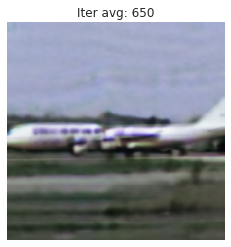

img min max:
0.8322749 0.14827873
loss tensor(0.1017, device='cuda:0', grad_fn=<MseLossBackward0>)


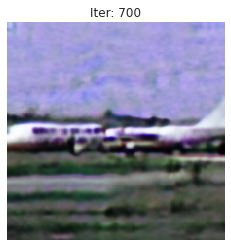

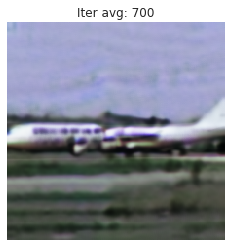

img min max:
0.8322749 0.14827873
loss tensor(0.0989, device='cuda:0', grad_fn=<MseLossBackward0>)


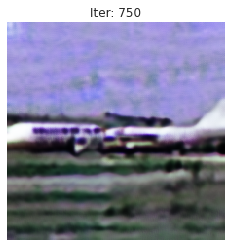

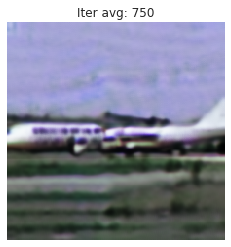

img min max:
0.8322749 0.14827873
loss tensor(0.1000, device='cuda:0', grad_fn=<MseLossBackward0>)


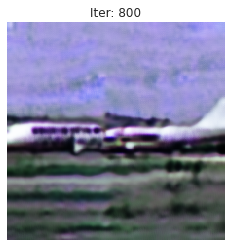

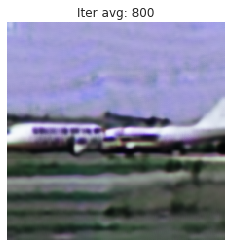

img min max:
0.8322749 0.14827873
loss tensor(0.0979, device='cuda:0', grad_fn=<MseLossBackward0>)


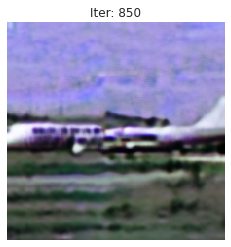

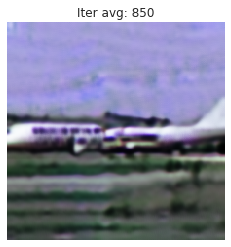

img min max:
0.8322749 0.14827873
loss tensor(0.0963, device='cuda:0', grad_fn=<MseLossBackward0>)


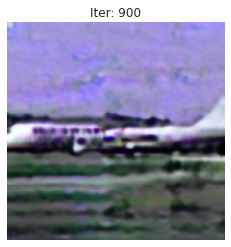

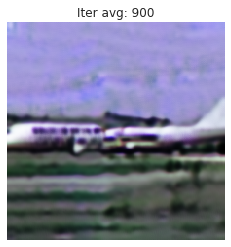

img min max:
0.8322749 0.14827873
loss tensor(0.0969, device='cuda:0', grad_fn=<MseLossBackward0>)


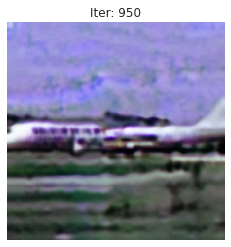

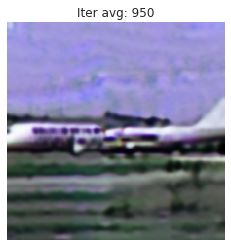

img min max:
0.8322749 0.14827873
loss tensor(0.0934, device='cuda:0', grad_fn=<MseLossBackward0>)


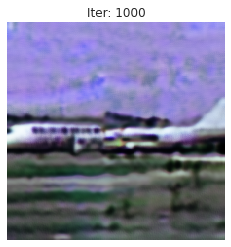

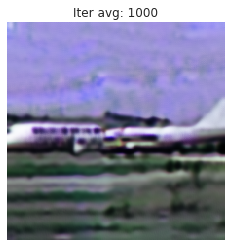

In [7]:

target_measured = torch.from_numpy(single_sub_fmri_val[30,inds]).unsqueeze(0).float().cuda()

reg_noise_std = 1./30.
def total_variation_loss(img, weight= 1.0):
    bs_img, c_img, h_img, w_img = img.size()
    tv_h = torch.pow(img[:,:,1:,:]-img[:,:,:-1,:], 2).sum()
    tv_w = torch.pow(img[:,:,:,1:]-img[:,:,:,:-1], 2).sum()
    return weight*(tv_h+tv_w)/(bs_img*c_img*h_img*w_img)


def norm_6(img):
    return torch.pow(torch.mean(torch.pow(img,6)),1.0/6)
    


# save tmp PSNR for different learning strategies
fancy_sgd_noise_psnr_list = [] # psnr between out and noise image
fancy_sgd_psnr_list = [] # psnr between sgd out and gt
fancy_sgd_expm_psnr_list = [] # psnr between exp avg and gt
fancy_sgd_out_1800 = None
fancy_sgd_expm_out_1800 = None
def closure():

    global i, out_avg, psrn_noisy_last, last_net, net_input
    if reg_noise_std > 0:
        net_input = net_input_saved + (noise.normal_() * reg_noise_std)
    out = net(net_input)

    if out_avg is None:
        out_avg = out.detach()
    else:
        out_avg = out_avg * exp_weight + out.detach() * (1 - exp_weight)
    
    enc_in = (out-mean)/std
    vox_pred = model(enc_in, inds_torch.unsqueeze(0).cuda() )
    
    loss = F.mse_loss(vox_pred, target_measured)#+total_variation_loss(out)+0.01*norm_6(out)#- 0.1*torch.mean(F.cosine_similarity(vox_pred, target))

    if i % show_every == 0:

        print('img min max:')
        print(rec_img_np.max(),rec_img_np.min())
        print('loss',loss)

    loss.backward()

    out_np = out.detach().cpu().numpy()[0]
    out_avg_np = out_avg.detach().cpu().numpy()[0]

    if i % show_every == 0:
        np_plot(out.detach().cpu().numpy()[0], 'Iter: '+str(i))
        np_plot(out_avg_np, 'Iter avg: '+str(i))


    i += 1
    return loss

## Optimizing 
print('Starting optimization with ADAM')
optimizer = torch.optim.Adam(net.parameters(), lr=LR)
for j in range(num_iter):
    optimizer.zero_grad()
    closure()
    optimizer.step()

torch.cuda.empty_cache()

encoder inversion 

Starting optimization with ADAM
img min max:
0.80615866 0.1422868
loss tensor(0.7614, device='cuda:0', grad_fn=<AddBackward0>)


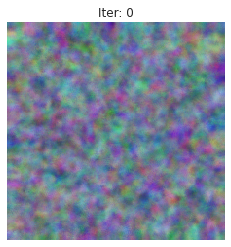

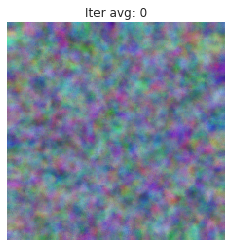

img min max:
0.80615866 0.1422868
loss tensor(0.1981, device='cuda:0', grad_fn=<AddBackward0>)


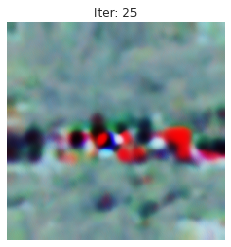

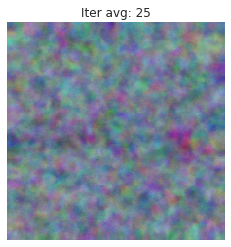

img min max:
0.80615866 0.1422868
loss tensor(0.1557, device='cuda:0', grad_fn=<AddBackward0>)


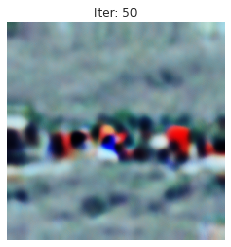

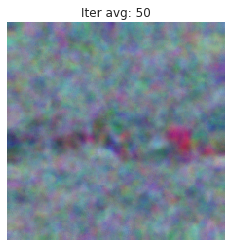

img min max:
0.80615866 0.1422868
loss tensor(0.1412, device='cuda:0', grad_fn=<AddBackward0>)


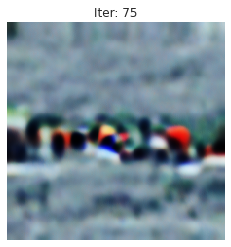

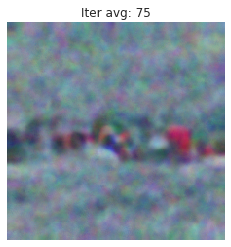

img min max:
0.80615866 0.1422868
loss tensor(0.1351, device='cuda:0', grad_fn=<AddBackward0>)


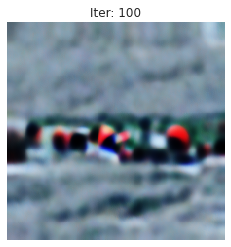

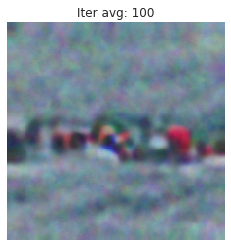

img min max:
0.80615866 0.1422868
loss tensor(0.1303, device='cuda:0', grad_fn=<AddBackward0>)


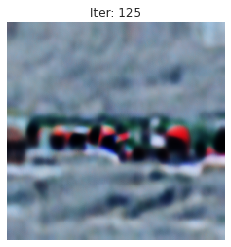

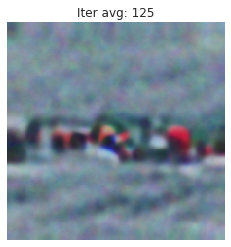

img min max:
0.80615866 0.1422868
loss tensor(0.1271, device='cuda:0', grad_fn=<AddBackward0>)


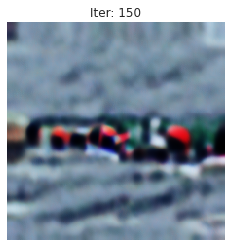

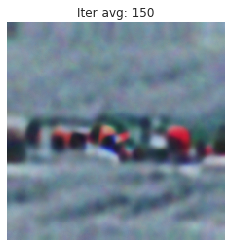

img min max:
0.80615866 0.1422868
loss tensor(0.1267, device='cuda:0', grad_fn=<AddBackward0>)


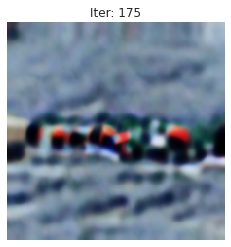

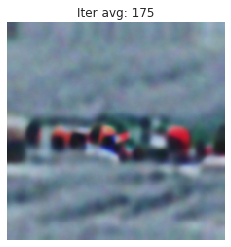

img min max:
0.80615866 0.1422868
loss tensor(0.1205, device='cuda:0', grad_fn=<AddBackward0>)


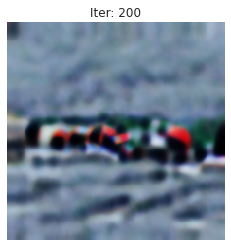

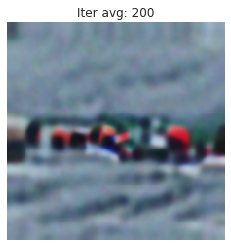

img min max:
0.80615866 0.1422868
loss tensor(0.1225, device='cuda:0', grad_fn=<AddBackward0>)


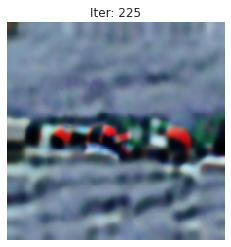

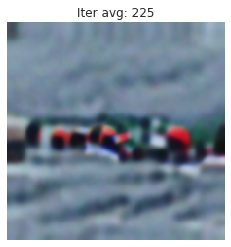

img min max:
0.80615866 0.1422868
loss tensor(0.1185, device='cuda:0', grad_fn=<AddBackward0>)


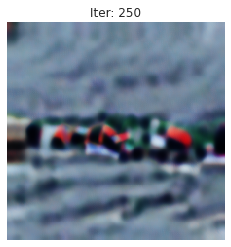

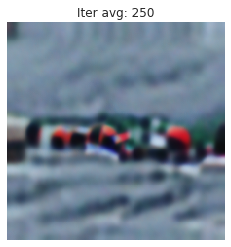

img min max:
0.80615866 0.1422868
loss tensor(0.1181, device='cuda:0', grad_fn=<AddBackward0>)


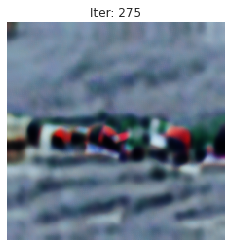

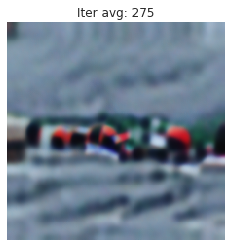

img min max:
0.80615866 0.1422868
loss tensor(0.1158, device='cuda:0', grad_fn=<AddBackward0>)


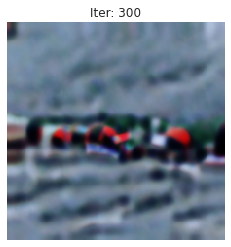

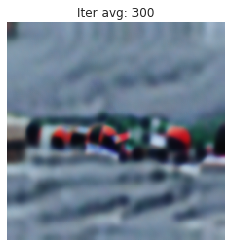

img min max:
0.80615866 0.1422868
loss tensor(0.1194, device='cuda:0', grad_fn=<AddBackward0>)


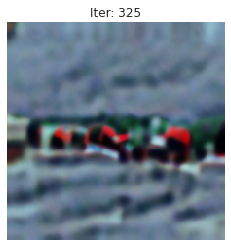

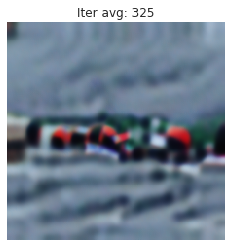

img min max:
0.80615866 0.1422868
loss tensor(0.1136, device='cuda:0', grad_fn=<AddBackward0>)


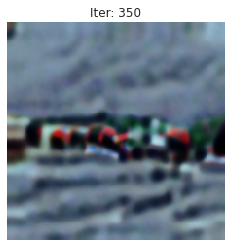

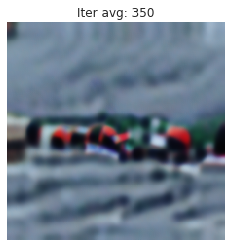

img min max:
0.80615866 0.1422868
loss tensor(0.1139, device='cuda:0', grad_fn=<AddBackward0>)


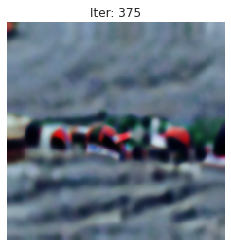

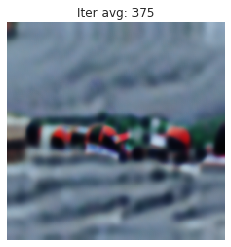

img min max:
0.80615866 0.1422868
loss tensor(0.1146, device='cuda:0', grad_fn=<AddBackward0>)


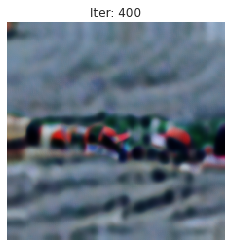

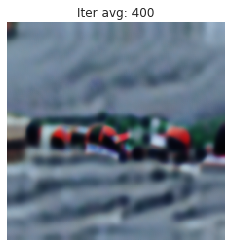

img min max:
0.80615866 0.1422868
loss tensor(0.1120, device='cuda:0', grad_fn=<AddBackward0>)


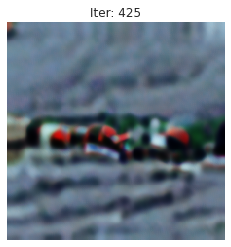

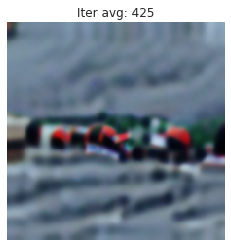

img min max:
0.80615866 0.1422868
loss tensor(0.1159, device='cuda:0', grad_fn=<AddBackward0>)


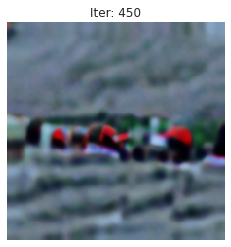

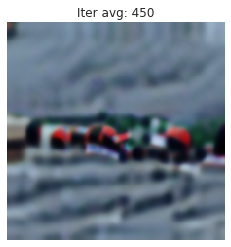

img min max:
0.80615866 0.1422868
loss tensor(0.1117, device='cuda:0', grad_fn=<AddBackward0>)


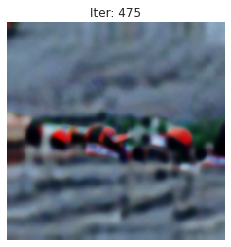

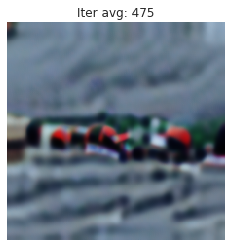

img min max:
0.80615866 0.1422868
loss tensor(0.1088, device='cuda:0', grad_fn=<AddBackward0>)


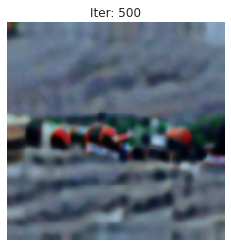

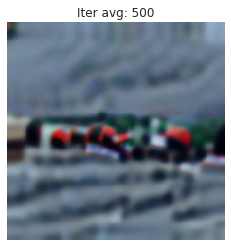

In [24]:

target_measured = torch.from_numpy(single_sub_fmri_val[30,inds]).unsqueeze(0).float().cuda()


reg_noise_std = 1./30.


def total_variation_loss(img, weight= 1.0):
    bs_img, c_img, h_img, w_img = img.size()
    tv_h = torch.pow(img[:,:,1:,:]-img[:,:,:-1,:], 2).sum()
    tv_w = torch.pow(img[:,:,:,1:]-img[:,:,:,:-1], 2).sum()
    return weight*(tv_h+tv_w)/(bs_img*c_img*h_img*w_img)


def norm_6(img):
    return torch.pow(torch.mean(torch.pow(img,6)),1.0/6)
    
    
net = get_net(input_depth, 'skip', pad,
            skip_n33d=128, 
            skip_n33u=128,
            skip_n11=2,
            num_scales=3,
            upsample_mode='bilinear').type(dtype)

## Optimize
net_input = get_noise(input_depth, INPUT, (224, 224),var=0.1).type(dtype).detach()
net_input_saved = net_input.detach().clone()
noise = net_input.detach().clone()
out_avg = None
last_net = None
psrn_noisy_last = 0
i = 0

out = net(net_input)
rec_img_np = out.detach().cpu().numpy()[0]



# save tmp PSNR for different learning strategies
fancy_sgd_noise_psnr_list = [] # psnr between out and noise image
fancy_sgd_psnr_list = [] # psnr between sgd out and gt
fancy_sgd_expm_psnr_list = [] # psnr between exp avg and gt
fancy_sgd_out_1800 = None
fancy_sgd_expm_out_1800 = None
def closure():

    global i, out_avg, psrn_noisy_last, last_net, net_input
    if reg_noise_std > 0:
        net_input = net_input_saved + (noise.normal_() * reg_noise_std)
    out = net(net_input)

    if out_avg is None:
        out_avg = out.detach()
    else:
        out_avg = out_avg * exp_weight + out.detach() * (1 - exp_weight)
    
    enc_in = (out-mean)/std
    vox_pred = model(enc_in, inds_torch.unsqueeze(0).cuda() )
    
    loss = F.mse_loss(vox_pred, target_measured)+total_variation_loss(out)+0.01*norm_6(out)#- 0.1*torch.mean(F.cosine_similarity(vox_pred, target))

    if i % show_every == 0:

        print('img min max:')
        print(rec_img_np.max(),rec_img_np.min())
        
        
        print('loss',loss)

    loss.backward()

    out_np = out.detach().cpu().numpy()[0]
    out_avg_np = out_avg.detach().cpu().numpy()[0]

    if i % show_every == 0:
        np_plot(out.detach().cpu().numpy()[0], 'Iter: '+str(i))
        np_plot(out_avg_np, 'Iter avg: '+str(i))
    i += 1
    return loss

## Optimizing 
print('Starting optimization with ADAM')
optimizer = torch.optim.Adam(net.parameters(), lr=LR)
for j in range(num_iter):
    optimizer.zero_grad()
    closure()
    optimizer.step()

torch.cuda.empty_cache()